This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data). The synthesis model is a logistic/multinomial logistic regression. The model used for the KS-statistic calculation is a CART.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

In [2]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
    
    full_X = poly.fit_transform(full_X)

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

Import the data.

In [3]:
# import standardized lat/long location data
train_data = pd.read_csv("Data/synthetic_datasets/train_dataset.csv")

***

Testing logistic and multinomial logistic regression synthesizers.

In [4]:
def polynomial_and_standardize(dataset, poly_degree=3, interaction_only=False):
    
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only, include_bias=False)
    
    X = poly.fit_transform(dataset)
    
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    
    return scaled_X

In [5]:
def multinomial_synthesizer(orig_data, synth_data_sets, target, penalty_param, poly_degree=3, interaction_only=False):
    
    mn_model = LogisticRegression(penalty='l1', C=penalty_param, solver='saga', max_iter=1000, multi_class='multinomial', random_state=rng)
    
    X = polynomial_and_standardize(dataset=orig_data, poly_degree=poly_degree, interaction_only=interaction_only)
    
    sXs = [polynomial_and_standardize(dataset=Y, poly_degree=poly_degree, interaction_only=interaction_only) for Y in synth_data_sets]
    
    vals = []
    
    mn_model.fit(X, target)
    
    rng_mn = default_rng()
    
    for Y in sXs:
        
        probs = mn_model.predict_proba(Y)
    
        v = [np.argmax(rng_mn.multinomial(n=1, pvals=p, size=1)==1) for p in probs]
    
        vals.append(pd.Series(v, name=target.name))
    
    return vals

In [6]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [7]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "C_sex_": (0.001, 2),
            "C_age_": (0.001, 2),
            "C_state_": (0.001, 2)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.set_gp_params(alpha=1e-3)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [8]:
nsd = 20
ngi = 5
random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
# random_states = [np.random.RandomState(1234)]

In [9]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.1851   | 0.3838    | 1.245     | 0.876     | 672.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.2291   | 1.56      | 0.5459    | 0.5537    | 681.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.1741   | 1.916     | 1.752     | 0.7163    | 501.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.1994   | 1.367     | 1.426     | 0.7411    | 537.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.04487  | 1.007     | 0.02852   | 1.546     | 730.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.2403   | 1.208     | 0.983     | 0.7243    | 737.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.2044   | 1.953     | 0.2985    | 0.9235    | 495.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 8         | -0.2231   | 0.882     | 0.6037    | 1.584     | 730.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1219   | 0.8375    | 1.151     | 0.1834    | 712.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.2198   | 1.997     | 1.119     | 1.475     | 338.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.2791   | 1.845     | 0.4987    | 1.494     | 413.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.2004   | 0.7708    | 1.216     | 1.323     | 687.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 13        | -0.2386   | 1.735     | 1.616     | 1.189     | 216.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.2584   | 1.788     | 1.331     | 0.867     | 725.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.1511   | 0.9973    | 0.8956    | 0.3643    | 746.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.1978   | 1.923     | 0.5842    | 0.6463    | 558.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.2434   | 1.791     | 1.797     | 1.986     | 596.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 18        | -0.7272   | 0.4745    | 1.326     | 0.006036  | 688.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.2121   | 1.371     | 0.4365    | 0.5479    | 681.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.1988   | 1.617     | 0.2248    | 1.47      | 730.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.2235   | 1.006     | 0.2282    | 1.611     | 683.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.1547   | 0.9442    | 1.113     | 0.5938    | 711.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.233    | 1.025     | 0.2394    | 1.397     | 730.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.1569   | 0.7304    | 1.565     | 0.335     | 711.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.214    | 1.043     | 0.8038    | 0.5652    | 712.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.169    | 1.687     | 1.511     | 0.4361    | 350.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.2114   | 0.765     | 1.932     | 1.139     | 600.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 28        | -0.2016   | 1.053     | 0.2621    | 1.952     | 730.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.2004   | 1.817     | 1.716     | 0.7884    | 252.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 30        | -0.0396   | 0.7313    | 1.193     | 0.1231    | 711.5     |
Final Result:  {'target': -0.03959605222638734, 'params': {'C_age_': 0.7313489655979388, 'C_sex_': 1.1925153505672823, 'C_state_': 0.12312498114985924, 'num_components_': 711.5452835303347}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.1073   | 0.1425    | 1.63      | 1.536     | 372.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.1453   | 0.387     | 1.958     | 0.8131    | 655.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 3         | -0.1345   | 0.1792    | 0.6205    | 1.238     | 476.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.234    | 0.4374    | 1.327     | 1.358     | 771.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.2038   | 0.5632    | 1.24      | 0.7672    | 440.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.2179   | 0.541     | 1.717     | 1.082     | 372.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.1787   | 1.075     | 0.5335    | 0.7809    | 318.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

| 8         | -0.0887   | 0.2421    | 0.6919    | 0.5023    | 618.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.194    | 0.2895    | 1.905     | 1.972     | 372.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.2312   | 0.6124    | 1.412     | 1.229     | 392.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.2666   | 0.6516    | 1.66      | 1.726     | 572.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.158    | 1.163     | 0.896     | 0.497     | 319.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.2461   | 1.139     | 0.9629    | 1.876     | 706.1     |
| 14        | -0.04866  | 0.4522    | 1.224     | 0.1585    | 783.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.000441 | 0.8775    | 1.183     | 0.0479    | 498.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.2093   | 1.028     | 1.419     | 0.6854    | 764.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.1792   | 1.136     | 1.948     | 1.175     | 638.4     |
| 18        | -0.03099  | 0.4596    | 1.302     | 0.1472    | 762.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.1952   | 0.9242    | 1.79      | 0.8708    | 478.8     |
| 20        | -0.1867   | 0.5143    | 0.6913    | 0.4961    | 618.6     |
| 21        | -0.04348  | 0.04724   | 1.566     | 0.1273    | 524.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.08882  | 0.8134    | 0.6477    | 0.1971    | 285.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 23        | -0.2064   | 1.377     | 0.06506   | 1.33      | 514.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.164    | 0.8012    | 0.2254    | 0.5773    | 277.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.1819   | 0.6641    | 1.594     | 0.913     | 356.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.2133   | 0.9737    | 1.967     | 1.004     | 358.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.1429   | 0.7329    | 0.16      | 0.5479    | 515.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.004072 | 0.9288    | 0.6506    | 0.03002   | 341.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.2231   | 1.904     | 0.4353    | 0.723     | 454.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.2598   | 1.484     | 0.5965    | 1.834     | 676.4     |
Final Result:  {'target': -0.0004417239248360144, 'params': {'C_age_': 0.8774676948544637, 'C_sex_': 1.1830846625936988, 'C_state_': 0.047899097136926735, 'num_components_': 498.55909961264325}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.1493   | 1.033     | 0.6411    | 0.3371    | 231.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.1802   | 1.863     | 0.1187    | 0.8719    | 214.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.2723   | 0.9836    | 1.403     | 1.544     | 441.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.283    | 1.84      | 1.089     | 1.375     | 348.1     |
| 5         | -0.1389   | 0.4892    | 1.128     | 0.5327    | 341.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.05618  | 1.187     | 0.03213   | 0.7007    | 409.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.0848   | 0.91      | 1.548     | 0.1635    | 274.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.2057   | 0.7396    | 1.252     | 0.5954    | 542.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1945   | 1.221     | 1.466     | 1.921     | 688.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.2133   | 1.336     | 0.1029    | 1.409     | 700.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.1655   | 0.4635    | 1.199     | 1.975     | 609.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 12        | -0.02377  | 0.02088   | 1.254     | 0.5651    | 756.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.2449   | 1.928     | 0.2443    | 1.935     | 606.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.1543   | 1.927     | 1.434     | 0.2262    | 455.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.139    | 0.1268    | 1.647     | 1.81      | 377.1     |
| 16        | -0.06334  | 0.419     | 1.681     | 0.133     | 281.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.2177   | 1.103     | 1.834     | 0.9132    | 757.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.2845   | 1.555     | 1.685     | 1.248     | 413.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.2508   | 0.9239    | 1.24      | 1.58      | 670.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.2701   | 1.093     | 0.4214    | 1.627     | 791.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.1005   | 0.2042    | 1.43      | 1.254     | 458.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.2424   | 1.925     | 0.3659    | 0.8963    | 774.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.1933   | 1.944     | 1.98      | 0.6055    | 527.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.1531   | 0.1529    | 0.8751    | 1.592     | 254.5     |
| 25        | -0.0799   | 0.2785    | 0.4221    | 0.3331    | 708.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.2494   | 0.7559    | 0.53      | 1.165     | 586.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.002045 | 1.382     | 1.607     | 0.03503   | 566.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1982   | 1.419     | 1.634     | 0.5641    | 294.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.2432   | 0.4523    | 0.7636    | 1.951     | 786.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.1911   | 0.3485    | 0.4636    | 1.641     | 769.2     |
Final Result:  {'target': -0.002044534267607567, 'params': {'C_age_': 1.3823713804806221, 'C_sex_': 1.60674869233432, 'C_state_': 0.03503475195667408, 'num_components_': 566.1495812640661}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.241    | 1.948     | 1.977     | 0.7936    | 547.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.2574   | 1.116     | 0.6085    | 1.261     | 280.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.248    | 1.068     | 1.479     | 1.821     | 416.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.1408   | 0.08925   | 1.614     | 1.31      | 560.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.2495   | 1.17      | 0.3295    | 1.629     | 541.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.2597   | 0.5486    | 1.563     | 1.226     | 565.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.1837   | 0.2497    | 0.6826    | 1.6       | 220.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.1242   | 0.3314    | 0.0622    | 1.387     | 341.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.201    | 1.917     | 1.759     | 1.985     | 756.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.1845   | 0.7995    | 1.571     | 1.059     | 402.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.1609   | 1.073     | 0.1058    | 0.7024    | 592.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.2236   | 1.563     | 1.404     | 1.352     | 792.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.2166   | 0.9587    | 0.4504    | 0.6925    | 592.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.1852   | 0.9524    | 1.012     | 0.9089    | 752.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.2027   | 1.659     | 1.282     | 0.7652    | 678.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.1936   | 0.8223    | 0.5153    | 1.221     | 726.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.1851   | 1.199     | 0.728     | 0.4373    | 279.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.2039   | 0.7508    | 0.2129    | 1.466     | 280.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.1198   | 0.8936    | 0.6079    | 0.3633    | 245.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.1192   | 0.3782    | 0.2318    | 1.28      | 777.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.2337   | 1.21      | 0.4024    | 1.04      | 290.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.2526   | 1.698     | 0.9767    | 0.8588    | 693.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.1566   | 0.298     | 0.386     | 0.8737    | 757.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.08716  | 0.6985    | 0.01149   | 1.08      | 605.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.2003   | 1.273     | 0.6432    | 0.9414    | 532.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.009525 | 0.02779   | 0.06057   | 1.076     | 293.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.1748   | 1.347     | 1.81      | 0.5528    | 495.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.09952  | 1.268     | 0.2784    | 0.2273    | 634.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.2394   | 1.379     | 1.369     | 1.375     | 345.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.1672   | 1.015     | 0.2964    | 0.754     | 562.1     |
Final Result:  {'target': -0.009524877352591984, 'params': {'C_age_': 0.027794218500425835, 'C_sex_': 0.06057411378652153, 'C_state_': 1.0760680580470317, 'num_components_': 293.4746303805547}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.2422   | 1.732     | 0.6148    | 1.631     | 253.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modul

| 2         | -0.000340 | 1.613     | 1.407     | 0.03572   | 341.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.1491   | 0.4017    | 0.9889    | 0.5945    | 749.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.1296   | 1.354     | 0.6941    | 0.219     | 743.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.2353   | 0.7415    | 0.3954    | 1.932     | 360.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.128    | 1.705     | 1.246     | 0.2047    | 340.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.08045  | 0.9722    | 1.297     | 0.2135    | 341.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.1325   | 1.438     | 1.166     | 0.2902    | 341.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1958   | 1.178     | 1.185     | 0.3295    | 341.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.2485   | 0.5717    | 1.674     | 1.263     | 262.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.1334   | 0.5438    | 0.2519    | 0.3188    | 437.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.009057 | 0.6932    | 1.174     | 0.07095   | 764.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.2505   | 1.899     | 0.3385    | 1.093     | 487.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.2125   | 1.83      | 0.1607    | 0.9569    | 572.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.1994   | 0.9428    | 0.432     | 0.978     | 703.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.2136   | 0.2042    | 1.296     | 1.013     | 407.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.1492   | 0.4525    | 0.2362    | 0.9012    | 502.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.2231   | 0.8099    | 1.537     | 1.571     | 589.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.1878   | 0.4532    | 1.024     | 0.7957    | 287.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.2289   | 0.4456    | 0.7517    | 1.479     | 621.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.000582 | 0.02702   | 0.06881   | 1.504     | 413.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.1292   | 0.7622    | 0.7417    | 0.2796    | 388.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.2075   | 1.661     | 1.385     | 0.9281    | 661.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.2315   | 1.654     | 0.796     | 1.111     | 632.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.06259  | 1.132     | 1.932     | 0.1327    | 442.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.1712   | 1.911     | 0.2071    | 1.241     | 592.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 27        | -0.1633   | 0.2335    | 0.4059    | 1.768     | 701.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1608   | 1.208     | 0.7437    | 0.486     | 360.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.2486   | 0.5859    | 1.89      | 1.842     | 434.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.2425   | 1.448     | 0.4568    | 1.231     | 277.9     |
Final Result:  {'target': -0.00034039032511980915, 'params': {'C_age_': 1.6132907095296625, 'C_sex_': 1.4065674268977977, 'C_state_': 0.035716075947247405, 'num_components_': 341.2067323171185}}


In [10]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

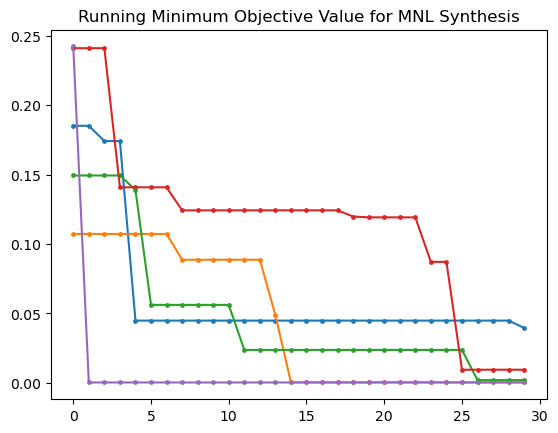

In [11]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [12]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [13]:
best_params

{'target': -0.00034039032511980915,
 'params': {'C_age_': 1.6132907095296625,
  'C_sex_': 1.4065674268977977,
  'C_state_': 0.035716075947247405,
  'num_components_': 341.2067323171185}}

Generate 20 synthetic data sets.

In [14]:
pmse_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_sex_=best_params['params']['C_sex_'],
                                             C_age_=best_params['params']['C_age_'],
                                             C_state_=best_params['params']['C_state_'])

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
np.mean(pmse_ratios)

0.9295442665854784

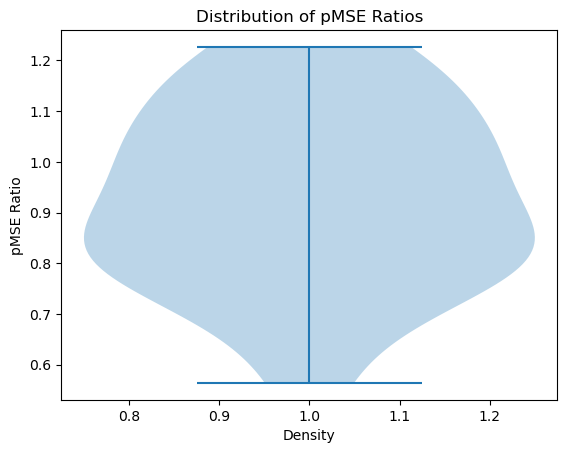

In [16]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [17]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("Data/synthetic_datasets/logistic_logistic_pmse_" + str(i) + ".csv", index=False)

***